# Laser Detection Algorithm on All Stars
Run the laser detection algorithm on all stars, using absolute median noise to determine threshold

In [1]:
import astropy.io.fits as fits
import matplotlib.pylab as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
import math
from mpmath import mp
import os
import os.path 
import random
from random import seed
from random import choice
from random import uniform
import mplcursors
import pandas as pd
from operator import itemgetter

from astropy import stats
import astropy
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 13})
plt.rcParams. update({'font.family':'serif'}) 

## Necessary Functions
First two functions cpied from Anna Zuckerman's Github repository: https://github.com/annazuckerman/specmatch-emp-apf

In [20]:
mp.dps=100
exp_array = np.frompyfunc(mp.exp, 1, 1)

# function to insert simulated gaussians by adding a gaussian into a given location in the spectrum
def insert_gaussian(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] + gauss
    return new_spect

# same as above, but REMOVES the part of the data where the gaussian is inserted
def insert_gaussian_with_data_removal(spectrum, gaussian_params, midpoint, numpoints):
    height = gaussian_params[0]
    position = gaussian_params[1] #position within segment, not index in spectrum
    FWHM = gaussian_params[2]
    offset = gaussian_params[3]
    x = np.linspace(0,numpoints-1,numpoints) # numpoints must be even
    width = FWHM/(2*np.sqrt(2*np.log(2)))    
    gauss = gaussian(x,height,position,width,offset)
    new_spect = spectrum.copy()
    new_spect[midpoint - math.floor(numpoints/2):midpoint + math.floor(numpoints/2)] = gauss
    return new_spect
    
def gaussian(x,a,b,c,d): # a = height, b = position of peak, c = width, x = numpy array of x values
    f = a*exp_array((-(x-b)**2)/(2*c)**2) + d
    return f 

def chi(model, data):
    '''given two arrays of the same length, calculate chi-squared'''
    return np.sum((data - model) ** 2)

## Set parameters

In [21]:
plot = False  # plt.show()
save_figs = True  # save figures into folders

# for establishing threshold: how many sigmas to go above median
n = 10
plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams.update({'font.size': 7})

In [22]:
# detected signals information
detected_widths = []
detected_heights = []
detected_indicies = []
detected_wavelengths = []
detected_max_flux_vals = []

star_indicies = [] # which star in the list the other values correspond to
threshold_vals = []

num_injections = 0
num_injections_above_threshold = 0
num_recoveries = 0

# table containing all the stars and detections
column_names = ['star', 'index', 'ndetections']
total_detections = pd.DataFrame(columns = column_names)

## Read in Reduced Data from Anna Zuckerman's repo

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 19})

directory = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf'

# every file in Anna's NDR_corrected_wl_scale folder
list_of_files = []
for filename in os.listdir(directory):
    if filename.endswith(".fits"): 
        file_path = os.path.join(directory, filename)
        list_of_files = np.append(list_of_files, file_path)

## Create folder to store all results

In [24]:
# create Laser Detection Results folder
if save_figs == True:
    path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/10s-LaserDetectionResults/'
    if not (os.path.isdir(path)):
        os.mkdir(path)

## Run algorithm on all stars in Anna's folder

1


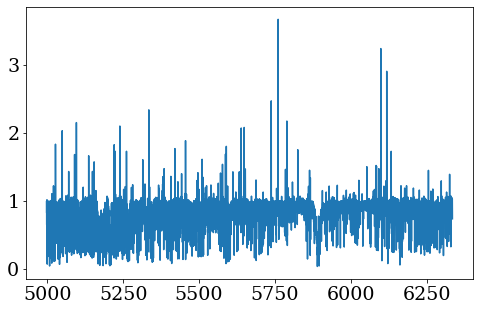

Star: HIP4845
[array([41887, 41888]), array([58701, 58702]), [59642]]
[41887 41888]
[58701 58702]
[59642]


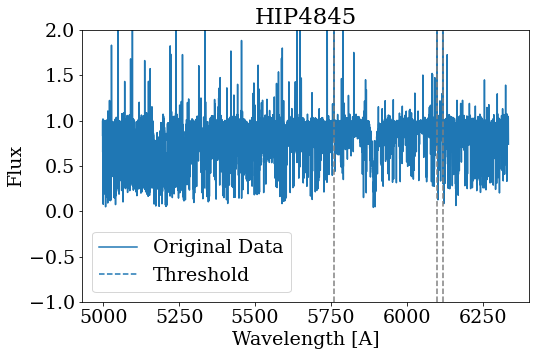

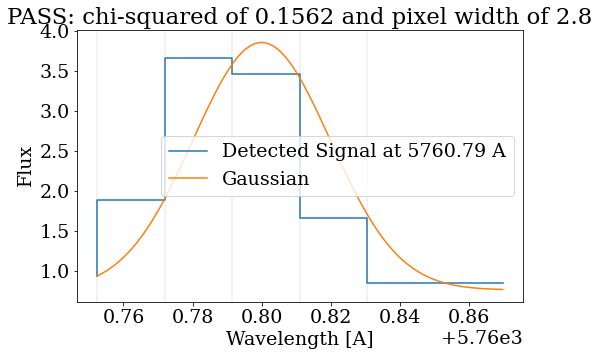

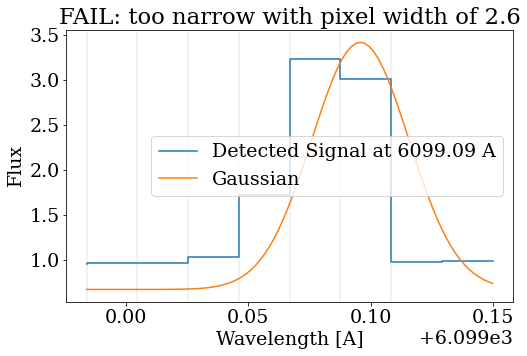

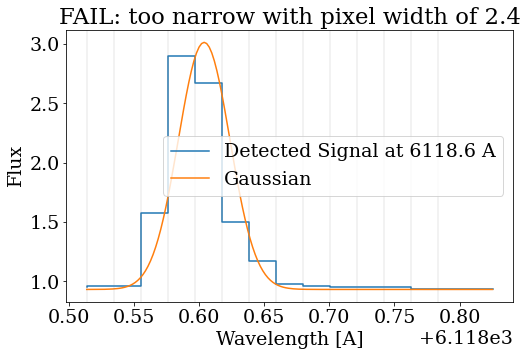

In [30]:
n = 25


for which_star in np.array([1]): # 896
# for which_star in random.sample(np.arange(len(list_of_files)).tolist(), 50):

# for which_star in np.arange(len(list_of_files)):

    print(which_star)
    
    # Get one star from list of all stars
    APF_flux_path = list_of_files[which_star]

    file = fits.open(APF_flux_path)
    flux = file[0].data
    wl = file[1].data
    
    plt.plot(wl, flux)
    plt.show()

    header = file[0].header
    star = header['OBJECT']

#     print('File path: ' + APF_flux_path)
    print('Star: ' + star)
        
    num_detections_this_star = 0
    # table containing info about this observation
    column_names = ['description', 'indicies']
    detections = pd.DataFrame(columns = column_names)

    spect = flux

    idxs1 = [] # indicies that are above continuum level
    idxs2 = [] # indicies in idxs1 that are above the threshold value and are local maximas
    idxs3 = [] # indicies in idxs2 that are gaussian-shaped
    idxs4 = [] # indicies in idxs3 that are greater than 5 pixels in width


    
#     clipped = astropy.stats.sigma_clip(spect, sigma=5).filled()
#     abs_dev = stats.median_absolute_deviation(clipped)
#     med = np.median(clipped)

    abs_dev = stats.median_absolute_deviation(spect)
    med = np.median(spect)

    T = med + n * abs_dev
    threshold_vals = np.append(threshold_vals, T)
    
    for idx in np.arange(len(spect)):
        if spect[idx] > T:
            idxs2 = idxs2 + [idx]

    consecutive_indicies_idxs2 = []
    i = 0
    while i < (len(idxs2)):
        lst = [idxs2[i]]
        while (i < len(idxs2) - 1) and (idxs2[i + 1] == idxs2[i] + 1):
            lst = np.append(lst, idxs2[i+1])
            i += 1
        consecutive_indicies_idxs2 = consecutive_indicies_idxs2 + [lst]
        i +=1

    median_indicies = []
    print(consecutive_indicies_idxs2)
    for idxs in consecutive_indicies_idxs2:
        print(idxs)
        
        max_index = max(idxs, key=lambda i: spect[i])
        median_indicies = np.append(median_indicies, int(max_index))

    idxs2 = np.array(median_indicies, dtype=int)
    num_injections_above_threshold += len(idxs2)
    
    
    
    

    detection_plot = False

    for idx in idxs2:
        # fit a gaussian to the peak, see if the width is greater than or equal to 2 pixels
        # see how much signal resembles a gaussian
        # if last test is commented out, ALSO check FWHM of gaussian

        # DETERMINING EDGES OF SIGNAL: mark edge when flux reaches a local minimum
        # PRO: can identify two signals together
        # CON: can't deal with noise in signal

        temp_ind = idx
        left_bound = 0
        while temp_ind > 1:
            temp_ind -= 1
            if spect[temp_ind] < spect[temp_ind - 1] and spect[temp_ind] < spect[temp_ind + 1]:
                left_bound = temp_ind
                break
        temp_ind = idx
        right_bound = len(spect) - 1
        while temp_ind < len(spect) - 4:
            temp_ind += 1
            if (spect[temp_ind] < spect[temp_ind - 1]) and (spect[temp_ind] < spect[temp_ind + 1]):
                right_bound = temp_ind
                break

        x = wl[left_bound:right_bound + 2]
        y = spect[left_bound:right_bound + 2]

        # oversample detected signal to determine precise bounds on the edges of the signal
        # use this to determine the FWHM of the signal in pixels
        oversampled_x = np.linspace(x[0], x[-1], len(x) * 10)
        spl = splrep(x, y, k=2)
        oversampled_y = splev(oversampled_x, spl)

        max_y = max(oversampled_y)
        min_y = np.percentile(oversampled_y, 3) 
        height = max_y - min_y
        ind = oversampled_y.tolist().index(max_y)
        pos = oversampled_x[ind]
        min_width = 0.00001
        max_width = oversampled_x[len(oversampled_x) - 1] - oversampled_x[0]
        width_spacing = 0.001

        chi_squared_values = []
        width_vals = np.arange(min_width, max_width, width_spacing)
        for w in width_vals:
            gaus = gaussian(oversampled_x, height, pos, w, min_y)
            chi_squared = chi(gaus, oversampled_y)
            chi_squared_values = np.append(chi_squared_values, chi_squared)
        min_chi_squared = min(chi_squared_values)
        ind_of_min_chisquared = chi_squared_values.tolist().index(min_chi_squared)
        width = width_vals[ind_of_min_chisquared]
        gaus = gaussian(oversampled_x, height, pos, width, min_y)

        width_threshold = False
        gauss_threshold = False

        # see if the signal fits a gaussian
        if min_chi_squared < 11:
            gauss_threshold = True
            idxs3 = idxs3 + [idx]

            # find the width of the gaussian in pixels

            peak = max(gaus)
            half_max = peak - height / 2

            peak_index = gaus.tolist().index(peak)
            temp_left_bound = peak_index
            temp_right_bound = peak_index

            while gaus[temp_left_bound] > half_max and temp_left_bound > 0:
                temp_left_bound -=1

            while gaus[temp_right_bound] > half_max and temp_right_bound < len(gaus) - 1:
                temp_right_bound += 1

            pixel_width = (temp_right_bound - temp_left_bound) / 10

            if pixel_width > 2.7:
                width_threshold = True
                idxs4 = idxs4 + [idx]
                num_detections_this_star += 1
        
        
        if plot == True or save_figs == True:
            
            if detection_plot == False:
                detection_plot = True
                
                # make a folder for this star
                path = '/mnt_home/zoek/code/APF-BL-DAP/Zoe/10s-LaserDetectionResults/' + str(which_star) + '_' + star
                if not (os.path.isdir(path)):
                    os.mkdir(path)

                fig = plt.figure()
                plt.plot(wl, spect, label = 'Original Data')
                if (len(idxs2) > 0):
                    for ind in idxs2:
                        plt.axvline(x=wl[ind], color='gray', linestyle='--')
                plt.axhline(y=T, linestyle='--', label='Threshold')
                plt.title(star)
                plt.xlabel('Wavelength [A]')
                plt.ylabel('Flux')
                plt.legend() 
                plt.ylim(-1, 2)
                if plot == True:
                    plt.show()
                if save_figs == True:
                    fig.savefig(path + '/' + star + 'data.png')
            
            
            
            
            
            fig = plt.figure()
            plt.step(x, y, label = 'Detected Signal at ' + str(round(wl[idx], 2)) + ' A')
            plt.plot(oversampled_x, gaus, label = 'Gaussian')
            if width_threshold == True:
                # passed width threshold AND gaussian threshold
                plt.title('PASS: chi-squared of ' + str(round(min_chi_squared, 4)) + ' and pixel width of ' + str(pixel_width))
            elif gauss_threshold == True and width_threshold == False:
                # failed width threshold
                plt.title('FAIL: too narrow with pixel width of ' + str(pixel_width))
            else:
                # failed gaussian threshold
                plt.title('FAIL: not gaussian-shaped: chi-squared of ' + str(round(min_chi_squared, 4)))

            plt.xlabel('Wavelength [A]')
            plt.ylabel('Flux')
            for ind in np.arange(left_bound, right_bound):
                plt.axvline(x=wl[ind], color='gray', linestyle='-', linewidth=0.2)
            plt.legend()
            if plot == True:
                plt.show()
            if save_figs == True:
                name = str(idx)
                fig.savefig(path + '/' + name + '.png')
                
    wavelengths = []
    for i in idxs4:
        w = wl[i]
        wavelengths += [w]

    new1 = {'description': ['indicies above threshold', 'indicies that are gaussian-shaped', 'indicies wider than PSF'],
            'indicies': [idxs2.tolist(), idxs3, idxs4], 'wavelengths': [[], [], wavelengths]}
    
    df1 = pd.DataFrame(new1)
    detections = detections.append(df1)
    name = str(which_star) + '_' + star
    if save_figs == True and detection_plot == True:
        detections.to_csv(path + '/' + name + '.csv')
    

        
    
    new2 = {'star': [star], 'index': [which_star], 'ndetections': [num_detections_this_star]}
    df2 = pd.DataFrame(new2)
    total_detections = total_detections.append(df2)

In [31]:
total_detections

,star,index,ndetections
0,HIP4845,1,1


## Save a table containing all the spectra and their number of detections

In [3]:
if save_figs == True:
    total_detections.to_csv('/home/zoek/code/APF-BL-DAP/Zoe/10s-LaserDetectionResults/results.csv')
else:
    print(total_detections)

NameError: name 'save_figs' is not defined

# Results

In [10]:
df = pd.read_csv('/home/zoek/code/APF-BL-DAP/Zoe/10s-LaserDetectionResults/results.csv')

In [11]:
df.sort_values('ndetections')

,Unnamed: 0,star,index,ndetections
302,0,TIC269701147,303,0
395,0,HIP112915,396,0
660,0,HIP23941,661,0
397,0,HIP73165,398,0
398,0,HIP101262,399,0
...,...,...,...,...
359,0,TIC298647682,360,29
466,0,TIC352413427,467,30
614,0,KIC3542116,615,38
766,0,TYC3010-1024-1,767,44


In [12]:
sum(df['ndetections'])

707

In [17]:
df[df['ndetections'].between(1, 10)]

,Unnamed: 0,star,index,ndetections
0,0,HIP4845,1,1
1,0,TIC158025009,2,3
10,0,HIP91430,11,1
24,0,HIP4849,25,1
37,0,GJ234,38,4
...,...,...,...,...
752,0,HIP69562,753,2
753,0,TIC94986319,754,2
758,0,TIC98796344,759,3
761,0,HIP56157,762,7


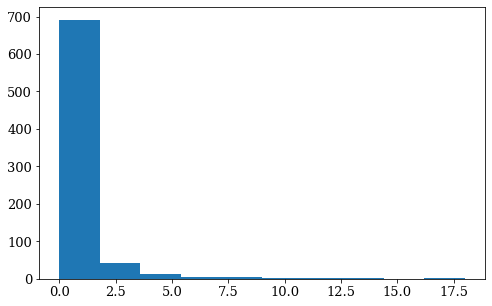

In [7]:
hist_det = df['ndetections']
hist_det = hist_det[hist_det < 20]
plt.hist(hist_det)
plt.show()

In [7]:
df[df['# Wider than PSF'] != 0]

KeyError: '# Wider than PSF'

In [8]:
num_detections = df['# Wider than PSF']

KeyError: '# Wider than PSF'

In [ ]:
num_detections_not_zero = num_detections[num_detections != 0]

In [ ]:
max(num_detections_not_zero)

In [ ]:
plt.hist(num_detections_not_zero)
plt.title('Detection Counts Histogram')
plt.xlabel('# Detections in Spectrum')
plt.ylabel('# Spectra')
# plt.xlim(2, 12)
plt.show()

In [ ]:
plt.hist(num_detections, bins = np.arange(13), align='right')
plt.title('Number of Detections in Spectra: 10 sigma threshold')
plt.xlabel('# Detections in a Spectrum')
plt.ylabel('# Spectra')
plt.xlim(0, 10)
plt.show()

In [ ]:
total_detections = sum(num_detections)
av_num_detections = np.average(num_detections)
median_num_detections = np.median(num_detections)

In [ ]:
print('Total # Detection: ' + str(total_detections))
print(str(sum(num_detections == 0)) + ' of these spectra have 0 detections')
print('Mean # Detections per Spectrum: ' + str(av_num_detections))
print('Median # Detections per Spectrum: ' + str(median_num_detections))
print(str(sum(num_detections == 0)) + ' of these spectra have 0 detections')